# Neural Networks Continued

This notebook will attempt to train some Neural Networks on the Training data and save it for later use. It is an extension of 014 as I kept running into problems there

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

I have tried to go through several U-net tutorials - all of which failed. I suspect there is a combination of problems affecting me:

- The tutorial data-sets are not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and built on old dependencies

- there is too much data being brought in for training at one time, for offline use

- the offline training I have been trying to do is not possible, as my Graphics Card does not have enough VRAM

To try and overcome these challenges - I am going to load a single folder from our data-set into some training variables, and attempt to train a model on just those. I am unable to do an example tutorial - so I am hoping for the best with my implementation

# Proposed problem

Up until this point, I have tried the following:

- Designing a Custom CNN, using a tutorial from: https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

- Using a Pre-Trained CNN, from Tensorflow: https://www.tensorflow.org/tutorials/images/segmentation

- Training with a resized set of training images

- Modifying the Masks, to limit the number of classes (to 5 as well as to 2)

- Modifying the Optimizers and parameters, to try improve accuracy

None of the above have been successful

What I am going to try now is to use Patchify to crop and break up the images into smaller pieces, and see if that improves things... I will following this tutorial: https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet

# Mount Drive

We need to access some images loaded into Google Drive, so here we mount it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

To try and fix the problems experienced in notebook 012, we will start by loading a larger dataset - all the GT images

# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Load images into variables

Fetch 1 folder

In [ ]:
getcwd()

'/content'

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

data_roots = []

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    # print(dirs)
    if ("X" in dirs):
      # print("Yes", root)
      data_roots.append(root) # get first directory
      break

data_roots


['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/01']

Next, we can append an "X" and "Y" tag onto each for the paths to our images

In [ ]:
x_paths = []
y_paths = []

for path in data_roots:
    x_paths.append( path + "/X" )
    y_paths.append( path + "/Y" )

Now, we can use those paths to load the images in each directory into training variables:

In [ ]:
x_image_paths = []

for path in x_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            x_image_paths.append( path + "/" + image )


In [ ]:
y_image_paths = []

for path in y_paths:
    for root, dirs, files in walk(path):
        # print(files)
        for image in files:
            y_image_paths.append( path + "/" + image )


In [ ]:
len(x_image_paths) == len(y_image_paths)

True

In [ ]:
print(len(x_image_paths))

15


Let's confirm that the images correspond:

In [ ]:
def extractRHS(string, symbol):
    index = string.rfind(symbol)
    # print(index)
    return string[ index + 1 : ]
###

extractRHS("219030365@stu.ukzn.zc.za", "@")

'stu.ukzn.zc.za'

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 10 : processed1_t092.tif and man_seg075.tif
Index: 5 : processed1_t112.tif and man_seg112.tif
Index: 11 : processed1_t049.tif and man_seg100.tif
Index: 13 : processed1_t067.tif and man_seg092.tif
Index: 13 : processed1_t067.tif and man_seg092.tif


They dont match! Perhaps Drive uses some kind of hashing function to store their files... Let us sort the lists:

In [ ]:
x_image_paths.sort()
y_image_paths.sort()

In [ ]:
from random import randint

for i in range(5):
    index = randint(0, len(x_image_paths)-1)

    print("Index:", index, ":", extractRHS(x_image_paths[index], "/"), 
          "and", extractRHS(y_image_paths[index], "/") )

Index: 1 : processed1_t005.tif and man_seg005.tif
Index: 6 : processed1_t059.tif and man_seg059.tif
Index: 9 : processed1_t075.tif and man_seg075.tif
Index: 12 : processed1_t100.tif and man_seg100.tif
Index: 3 : processed1_t007.tif and man_seg007.tif


# Patchify Tutorial

## Installs

In [ ]:
!pip install patchify
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.9 MB/s 


In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm

import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
scaler = MinMaxScaler()

# root_directory = 'Semantic segmentation dataset/'

patch_size = 256

Now, we need to go through each of the images in x_image_paths and patchify them

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  

for path in x_image_paths:
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = Image.fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") )
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
      image_dataset.append(single_patch_img)


Now patchifying image: processed1_t001.tif
Now patchifying image: processed1_t005.tif
Now patchifying image: processed1_t006.tif
Now patchifying image: processed1_t007.tif
Now patchifying image: processed1_t021.tif
Now patchifying image: processed1_t049.tif
Now patchifying image: processed1_t059.tif
Now patchifying image: processed1_t067.tif
Now patchifying image: processed1_t072.tif
Now patchifying image: processed1_t075.tif
Now patchifying image: processed1_t092.tif
Now patchifying image: processed1_t096.tif
Now patchifying image: processed1_t100.tif
Now patchifying image: processed1_t102.tif
Now patchifying image: processed1_t112.tif


In [ ]:
print("Length original images:", len(x_image_paths))
print("Length of patchified images", len(image_dataset))

Length original images: 15
Length of patchified images 60


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    # plt.axis('off')
  plt.show()


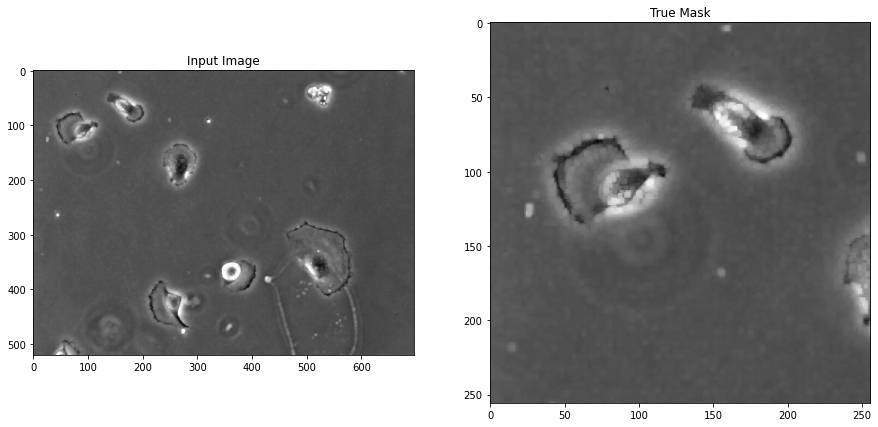

In [ ]:
array = [ cv2.imread(x_image_paths[0]), image_dataset[0]]

display( array )

As we can see from the above, our patchify images are pieces of the original!

Let us now repeat that for the masks

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
mask_dataset = []  

for path in y_image_paths:
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = Image.fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") )
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
      mask_dataset.append(single_patch_img)


Now patchifying image: man_seg001.tif
Now patchifying image: man_seg005.tif
Now patchifying image: man_seg006.tif
Now patchifying image: man_seg007.tif
Now patchifying image: man_seg021.tif
Now patchifying image: man_seg049.tif
Now patchifying image: man_seg059.tif
Now patchifying image: man_seg067.tif
Now patchifying image: man_seg072.tif
Now patchifying image: man_seg075.tif
Now patchifying image: man_seg092.tif
Now patchifying image: man_seg096.tif
Now patchifying image: man_seg100.tif
Now patchifying image: man_seg102.tif
Now patchifying image: man_seg112.tif


In [ ]:
print("Length original images:", len(y_image_paths))
print("Length of patchified images", len(mask_dataset))

Length original images: 15
Length of patchified images 60


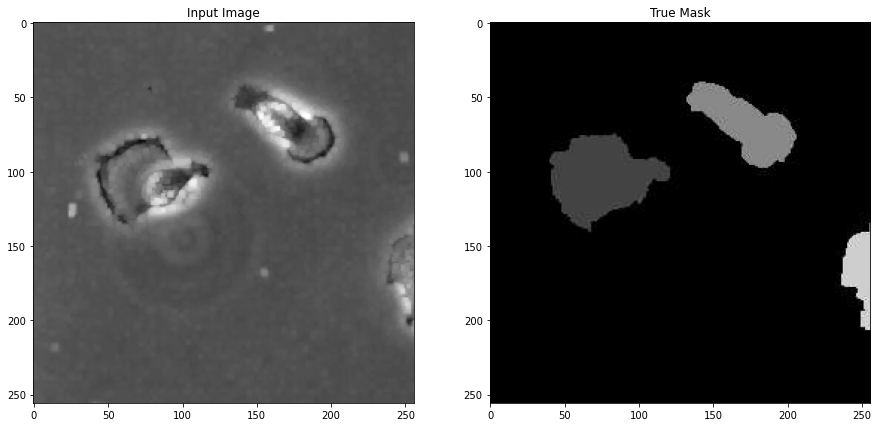

In [ ]:
array = [ image_dataset[0], mask_dataset[0] ]

display( array )

Okay! we are making progress now! Let us keep going:

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=4) # shuffles and partitions data


# Try previous Model

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-38pqyqeg
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-38pqyqeg
  Created wheel for tensorflow-examples: filename=tensorflow_examples-9eb657f949c2e8ec8592a9576811db38a86dcbc0_-py3-none-any.whl size=299703 sha256=35b0108851fa2b2aa86b864d3bc566b9833151d651b58b87e30a3d7168d675a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-_k1bfe3p/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt


from tensorflow import keras

from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
sample_image, sample_mask = x_train[0], y_train[0]

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [ ]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(tensorflow_model.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

1/1 [==============================] - 1s 843ms/step


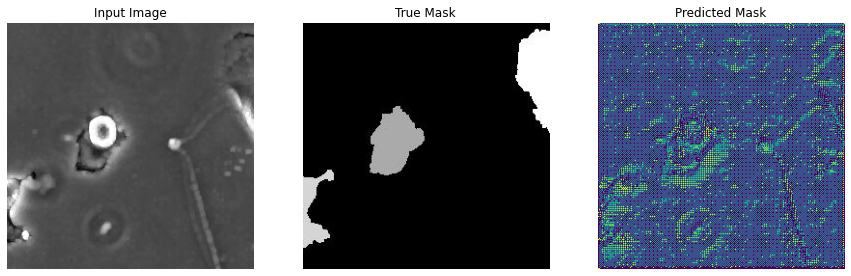

In [ ]:
# predict before training to see what happens
show_predictions(tensorflow_model)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(tensorflow_model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 98ms/step


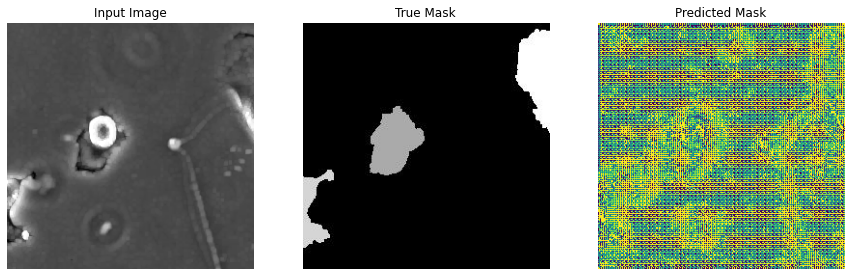


Sample Prediction after epoch 20

24/24 [==============================] - 11s 462ms/step - loss: 0.1788 - accuracy: 0.4014 - val_loss: 0.1617 - val_accuracy: 0.3890


In [ ]:


# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 20
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

# used in DisplayCallbackGeneric
temp_model = tensorflow_model
tensorflow_model_history = tensorflow_model.fit(
                                                x_train,
                                                y_train, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                callbacks=[DisplayCallback()],
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(x_test, y_test)
                                                )




That is very good! Let us try with a higher number of epochs and see if it improves

1/1 [==============================] - 0s 100ms/step


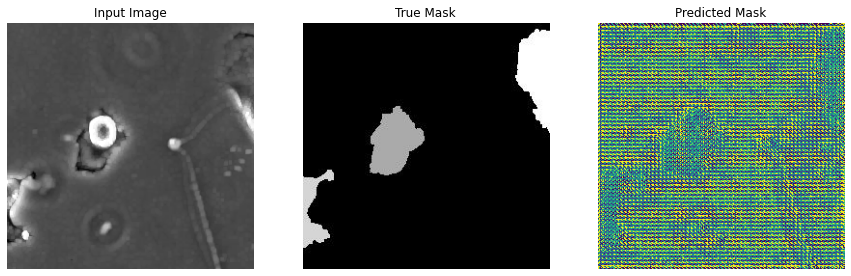


Sample Prediction after epoch 50

24/24 [==============================] - 11s 463ms/step - loss: 0.1788 - accuracy: 0.4255 - val_loss: 0.1617 - val_accuracy: 0.2712


In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model_2 = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model_2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])



# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 50
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

# used in DisplayCallbackGeneric
temp_model = tensorflow_model
tensorflow_model_2_history = tensorflow_model_2.fit(
                                                x_train,
                                                y_train, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                callbacks=[DisplayCallback()],
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(x_test, y_test)
                                                )




It is evident from the partitions that the masks I have loaded contain pixelation - which may be as a result of my early processing from Tiff to JPG (or the other way around) so a notebook trying to apply a watershed segmentation, or morphological operation (or something else) may help us fix this problem